<a href="https://colab.research.google.com/github/andreabazerla/real-estate/blob/main/Housing_Price_Prediction_in_Milan_(Italy)_through_Deep_Learning_via_immobiliare_it.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Housing Price Prediction in Milan (Italy) through Deep Learning via immobiliare.it

<img src="https://media.giphy.com/media/gTURHJs4e2Ies/source.gif" />

## Web Scraping: immobiliare.it

In [ ]:
import os
import logging
import math
import pandas as pd
import numpy as np
import seaborn as sb
from google.colab import files
import requests
from enum import Enum 
from random import uniform
import time
import datetime
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import re
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from sklearn.preprocessing import MultiLabelBinarizer
import functools
import matplotlib.pyplot as plt

In [ ]:
PRODUCTION = True
GET_ADS_LINKS = False
GET_ADS_LIST = True

In [ ]:
def get_timestamp():
  return str(int(time.time()))

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
class Contract(Enum):
  VENDITA = 'vendita'
  AFFITTO = 'affitto'
 
class Area(Enum):
  MILANO = 'milano'

In [ ]:
slash = '/'
https = 'https://'
website = 'www.immobiliare.it'
contract = Contract.VENDITA.value + '-case'
area = Area.MILANO.value
sort = '?criterio=rilevanza'
 
url = https + website + slash + contract + slash + area + slash + sort
 
print('url = ' + url)

In [ ]:
sleep_min = 2
sleep_max = 3

def sleep_default():
  time.sleep(uniform(sleep_min, sleep_max))

### Ads Link Scraping

In [ ]:
def get_last_page(url):
  sleep_default()
  
  try:
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")
  
    ul_pagination = soup.find("ul", class_ = "pagination pagination__number")
    li_list = ul_pagination.find_all("li")
    last_page = int(li_list[-1].get_text().strip())
  
    return last_page
  
  except requests.exceptions.RequestException as e:
    raise SystemExit(e)

#last_page = get_last_page(url)
#print('Last page = ' + str(last_page))

In [ ]:
def get_ads_link_list(url, first_page, last_page):
  ads_link_list = []
  
  pag = first_page
  
  while (pag <= last_page):
    if (pag > 1):
      url = url + '&pag=' + str(pag)
    
    try:
      response = requests.get(url)

      soup = BeautifulSoup(response.content, 'html.parser')
    
      ads_list = soup.find('ul', class_ = 'annunci-list')
      ad_item_list = ads_list.find_all('div', class_ = 'listing-item_body--content')
      for ad_item in ad_item_list:
        a_list = ad_item.find_all("a")
        for a in a_list:
          href = a["href"]
          ads_link_list.append(href)
    
    except Exception as e:
      logging.exception(e)
      print(str(pag))
      pass
    
    pag += 1
 
    sleep_default()
  
  return ads_link_list

In [ ]:
if PRODUCTION:
  if GET_ADS_LINKS:
    first_page = 1
    #last_page = 631
    last_page = get_last_page(url)
  
    ads_link_list = get_ads_link_list(url, first_page, last_page)
    ads_link_list = list(dict.fromkeys(ads_link_list))
    
    print('Total number of ads = ' + str(len(ads_link_list)))

In [ ]:
df_links = pd.DataFrame({'Links' : list(ads_link_list)})

csv_links = 'Links_' + str(int(time.time())) + '_' + str(first_page) + '_' + str(last_page) + '.csv'
df_links.to_csv(csv_links, index=False)

In [ ]:
display(df_links)

In [ ]:
files.download(csv_links)

### Ads Scraping

In [ ]:
def get_ad_title(soup):
  titleBlock__title = soup.find('span', class_ = 'im-titleBlock__title')
  if titleBlock__title is not None:
    return titleBlock__title.get_text()
  else:
    return ''

In [ ]:
def get_ad_price(soup):
  mainFeatures__price = soup.find_all('li', class_ = 'im-mainFeatures__price')
  if mainFeatures__price:
    return mainFeatures__price[0].get_text().replace('\n', '').strip()
  else:
    return ''

In [ ]:
def get_ad_main_feature(soup):
  main_features = {}
  
  mainFeatures = soup.find('div', class_ = 'im-mainFeatures')
  
  li_list = mainFeatures.find_all('li')
  for li in li_list[1:]:
    value = li.find('span', class_="im-mainFeatures__value").get_text().replace('\n', '').strip()
    label = li.find('span', class_="im-mainFeatures__label").get_text().replace('\n', '').strip()
    
    if (label == 'bagno' or label == 'bagni'):
      label = 'bagni'
    
    if (label == 'locale' or label == 'locali'):
      label = 'locali'
    
    main_features[label] = value
  
  return main_features

In [ ]:
def get_ad_description(soup):
  description__text = soup.find('div', class_ = 'im-description__text')
  if description__text is not None:
    return description__text.get_text()
  else:
    return ''

In [ ]:
def get_ad_locations(soup):
  location_list = []
  
  titleBlock__link = soup.find('a', class_ = 'im-titleBlock__link')
  if titleBlock__link is None:
    titleBlock__link = soup.find('h1', class_ = 'im-titleBlock__content')

  location = titleBlock__link.find_all('span', class_ = 'im-location')
  
  try:
    area = location[0].get_text().strip()
  except IndexError:
    area = ''
  
  try:
    district = location[1].get_text().strip()
  except IndexError:
    district = ''

  try:
    address = location[2].get_text().strip()
  except IndexError:
    address = ''

  return [area, district, address]

In [ ]:
def get_ad_feature_list(soup):
  features = {}
  
  features__list = soup.find_all("dl", class_ = "im-features__list")
  
  for feature_block in features__list:
    feature__title_list = feature_block.find_all('dt', class_ = 'im-features__title')
  
    for feature__title in feature__title_list:
      feature__value = feature__title.findNext('dd')
  
      if ('im-features__tagContainer' in feature__value.get('class')):
        features__tag_array = []

        features__tag_list = soup.find_all('span', class_ = 'im-features__tag')
        for feature__tag in features__tag_list:
          features__tag_array.append(feature__tag.get_text().strip())
  
        features__tag_list_string = ','.join(features__tag_array)
        feature__value_2 = features__tag_list_string
  
      else:
        feature__value_2 = feature__value.get_text().strip()
  
      feature__title_2 = feature__title.get_text().strip()
      features['f_' + feature__title_2] = feature__value_2
  
  return features

In [ ]:
def get_ad(url):
  if 'p-' in url:
    return get_ad_multi(url)
  else:
    return get_ad_single(url)

In [ ]:
def get_ad_single(url):
  ads_list = []
  ad_data = {}

  ad_data['url'] = url

  try:
    response = requests.get(url)
    if response:
      soup = BeautifulSoup(response.content, "html.parser")

      title = get_ad_title(soup);
      ad_data['titolo'] = title

      price = get_ad_price(soup);
      ad_data['prezzo'] = price

      main_features = get_ad_main_feature(soup)
      if main_features:
        ad_data.update(main_features)

      description = get_ad_description(soup);
      ad_data['descrizione'] = description

      area, district, address = get_ad_locations(soup)
      ad_data['area'] = area
      ad_data['quartiere'] = district
      ad_data['indirizzo'] = address

      feature_list = get_ad_feature_list(soup)
      if feature_list:
        ad_data.update(feature_list)

      ad_data['hashcode'] = hash(frozenset(ad_data.items()))

      ads_list.append(ad_data)
  
  except Exception as e:
    logging.exception(e)
    print(url)
    pass

  return ads_list

In [ ]:
def get_ad_multi(url):
  ads_list = []

  try:
    response = requests.get(url)
    if response:
      soup = BeautifulSoup(response.content, 'html.parser')

      title = get_ad_title(soup);

      area, district, address = get_ad_locations(soup)

      main_features = get_ad_main_feature(soup)

      description = get_ad_description(soup)

      feature_list = get_ad_feature_list(soup)

      properties__list = soup.find('ul', class_ = 'im-properties__list')
      properties__item_list = properties__list.find_all('li', class_ = 'im-properties__item')
      for properties__item in properties__item_list:
        ad_data = {}

        ad_data['url'] = url

        ad_data['titolo'] = title

        ad_data['area'] = area
        ad_data['quartiere'] = district
        ad_data['indirizzo'] = address
        
        price = get_ad_price(properties__item)
        ad_data['prezzo'] = price

        ad_data['descrizione'] = description

        sub_features = get_ad_main_feature(properties__item)
        if sub_features:
          ad_data.update(sub_features)

        title_2 = properties__item.find('p', class_ = 'nd-mediaObject__title')
        if title_2 is not None:
          ad_data['titolo_2'] = title_2.get_text().strip()

        description_2 = properties__item.find('div', class_ = 'im-properties__content')
        if description_2 is not None:
          ad_data['descrizione_2'] = description_2.get_text()

        if feature_list:
          ad_data.update(feature_list)

        ad_data['hashcode'] = hash(frozenset(ad_data.items()))

        ads_list.append(ad_data)

  except Exception as e:
    logging.exception(e)
    print(url)
    pass
  
  return ads_list

In [ ]:
df_links = pd.read_csv('Links_1616797839_1_630.csv')
ads_link_list = df_links['Links'].to_list()

In [ ]:
if PRODUCTION:
  if GET_ADS_LIST:
    df_ads = pd.DataFrame()

    first_ad = 1000
    last_ad = 1500
    #last_ad = len(ads_link_list)

    #if (first_ad > last_ad)
    
    ads_csv = 'Ads_' + get_timestamp() + '_' + str(first_ad) + '_' + str(last_ad - 1) + '.csv'

    ads_list = []
    for i in tqdm(range(first_ad, last_ad)):

      try:
        ad_data = get_ad(ads_link_list[i])
        for ad in ad_data:
          ads_list.append(ad)
      except Exception as e:
        logging.exception(e)
        print(i)
        pass
      
      sleep_default()
    
    df_ads = pd.DataFrame(ads_list)
    df_ads.fillna('', inplace=True)
    df_ads.to_csv(ads_csv, index=False)

In [ ]:
  display(df_ads)

In [ ]:
files.download(ads_csv)

In [ ]:
ads_folder = 'Ads'
file_list = os.listdir(ads_folder)
ads_files = [file for file in file_list if file.startswith('Ads')]
ads_files.sort()

df_files = [None] * len(ads_files)
for idx, file in enumerate(ads_files):
  df_files[idx] = pd.read_csv(os.path.join(ads_folder, file))

df_final = pd.concat(df_files).drop_duplicates().reset_index(drop=True)

ads_csv_final = 'Ads' + '_' + get_timestamp() + '.csv'
df_final.to_csv(ads_csv_final, index=False)

In [ ]:
files.download(ads_csv_final)

## Clean Ads CSV

In [ ]:
df_ads = pd.read_csv('Ads_1617101603.csv', dtype=str)

In [ ]:
df_ads_single = df_ads[~df_ads['url'].str.contains('p-')]

In [ ]:
print(df_ads_single['url'].duplicated().any())
print(df_ads_single['hashcode'].duplicated().any())

In [ ]:
index_names = df_ads_single[
  (df_ads_single['f_offerta minima'].notnull())
  | (df_ads_single['f_rialzo minimo'].notnull())
  | (df_ads_single['f_Spesa prenota debito'].notnull())
  | (df_ads_single['f_Contributo non dovuto'].notnull())
  | (df_ads_single['f_Tribunale'].notnull())
  | (df_ads_single['f_termine presentazione'].notnull())
  | (df_ads_single['f_lotto numero'].notnull())
  | (df_ads_single['f_Deposito cauzionale'].notnull())
  | (df_ads_single['f_luogo vendita'].notnull())
  | (df_ads_single['f_Luogo presentazione'].notnull())
  | (df_ads_single['f_categoria'].notnull())
  | (df_ads_single['f_Procedura'].notnull())
  | (df_ads_single['f_Procedura'].notnull())
  | (df_ads_single['f_numero procedura'].notnull())
  | (df_ads_single['f_Delegato'].notnull())
  | (df_ads_single['f_Giudice'].notnull())
  | (df_ads_single['f_Custode'].notnull())
  | (df_ads_single['f_Dati catastali'].notnull())
  | (df_ads_single['f_Rialzo minimo in caso di gara'].notnull())
  | (df_ads_single['f_Motivo esenzione'].notnull())
  | (df_ads_single['f_note'].notnull())
  | (df_ads_single['f_Rito'].notnull())
  | (df_ads_single['f_Curatore'].notnull())
  | (df_ads_single['f_Altri dati catastali'].notnull())
  | (df_ads_single['f_Deposito conto spese'].notnull())
  | (df_ads_single['f_Cauzione e spese'].notnull())
  | (df_ads_single['f_Referente'].notnull())
  | (df_ads_single['f_valore perizia'].notnull())
  | (df_ads_single['f_Delegato alla vendita'].notnull())
].index

df_ads_auction = df_ads_single.drop(index_names)

In [290]:
columns_useless = [
  #'url',
  'area',
  'descrizione',
  'titolo_2',
  'descrizione_2',
  'f_superficie',
  'f_prezzo',
  'f_riferimento e Data annuncio',
  'f_immobile garantito',
  'f_contratto',
  'f_unità',
  'f_Data di inizio lavori e di consegna prevista',
  'f_Indice prest. energetica rinnovabile',
  'f_Prestazione energetica del fabbricato',
  'f_disponibilità',
  'f_certificazione energetica',
  'f_numero immobili',
  'f_aggiornato il',
  'hashcode',
  'data vendita',
  'f_Tipo vendita',
  'f_data vendita',
  'f_offerta minima',
  'f_rialzo minimo',
  'f_Spesa prenota debito',
  'f_Contributo non dovuto',
  'f_Tribunale',
  'f_termine presentazione',
  'f_lotto numero',
  'f_Deposito cauzionale',
  'f_luogo vendita',
  'f_Luogo presentazione',
  'f_categoria',
  'f_Procedura',
  'f_numero procedura',
  'f_Delegato',
  'f_Giudice',
  'f_Custode',
  'f_Dati catastali',
  'f_Rialzo minimo in caso di gara',
  'f_Motivo esenzione',
  'f_note',
  'f_Rito',
  'f_Curatore',
  'f_Altri dati catastali',
  'f_Deposito conto spese',
  'f_Cauzione e spese',
  'f_Referente',
  'f_valore perizia',
  'f_Delegato alla vendita'
]

df_ads_columns = df_ads_auction.drop(columns_useless, axis=1)

In [291]:
df_ads_columns = df_ads_columns[df_ads_columns['f_Tipo proprietà'].notna()]
df_ads_columns.loc[df_ads_columns['f_Tipo proprietà'] == 'Classe immobile signorile', 'f_Tipo proprietà'] = 'Intera proprietà, classe immobile signorile'
df_ads_columns.loc[df_ads_columns['f_Tipo proprietà'] == 'Immobile di lusso', 'f_Tipo proprietà'] = 'Intera proprietà, immobile di lusso'
df_ads_columns.loc[df_ads_columns['f_Tipo proprietà'] == 'Classe immobile media', 'f_Tipo proprietà'] = 'Intera proprietà, classe immobile media'
df_ads_columns.loc[df_ads_columns['f_Tipo proprietà'] == 'Classe immobile economica', 'f_Tipo proprietà'] = 'Intera proprietà, classe immobile economica'

df_ads_columns = df_ads_columns[df_ads_columns['f_tipologia'].notna()]
df_ads_columns.loc[df_ads_columns['f_tipologia'] == 'Villa', 'f_tipologia'] = 'Villa unifamiliare'
df_ads_columns.loc[df_ads_columns['f_tipologia'] == 'Villa bifamiliare', 'f_tipologia'] = 'Villa plurifamiliare'

df_ads_columns = df_ads_columns[df_ads_columns['quartiere'].notna()]

df_ads_columns = df_ads_columns[df_ads_columns['f_stato'].notna()]

df_ads_columns = df_ads_columns[df_ads_columns['f_Efficienza energetica'].notna()]

df_ads_columns['prezzo'] = df_ads_columns['prezzo'].replace('[\€\,\.]', '', regex=True)
df_ads_columns['prezzo'] = df_ads_columns['prezzo'].str.extract(r'(\d+)')
df_ads_columns = df_ads_columns[df_ads_columns['prezzo'].notna()]
df_ads_columns['prezzo'] = df_ads_columns['prezzo'].astype(int)

df_ads_columns['superficie'] = df_ads_columns['superficie'].str.extract(r'(\d+)')
df_ads_columns = df_ads_columns[df_ads_columns['superficie'].notna()]
df_ads_columns['superficie'] = df_ads_columns['superficie'].astype(int)

df_ads_columns['bagni'] = df_ads_columns['bagni'].fillna('0')
df_ads_columns['bagni'] = df_ads_columns['bagni'].str.extract(r'(\d+)')
df_ads_columns['bagni'] = df_ads_columns['bagni'].astype(int)

df_ads_columns = df_ads_columns[df_ads_columns['locali'].notna()]
df_ads_columns['locali'] = df_ads_columns['locali'].str.extract(r'(\d+)')
df_ads_columns['locali'] = df_ads_columns['locali'].astype(int)

df_ads_columns['f_spese condominio'] = df_ads_columns['f_spese condominio'].str.extract(r'(\d+)')
df_ads_columns['f_spese condominio'] = df_ads_columns['f_spese condominio'].fillna(0)
df_ads_columns['f_spese condominio'] = df_ads_columns['f_spese condominio'].astype(int)

df_ads_columns['f_totale piani edificio'] = df_ads_columns['f_totale piani edificio'].str.extract(r'(\d+)')
df_ads_columns = df_ads_columns[df_ads_columns['f_totale piani edificio'].notna()]
df_ads_columns['f_totale piani edificio'] = df_ads_columns['f_totale piani edificio'].astype(int)
df_ads_columns = df_ads_columns[(df_ads_columns['f_totale piani edificio'] < 44)]

df_ads_columns = df_ads_columns[df_ads_columns['f_anno di costruzione'].notna()]
df_ads_columns['f_anno di costruzione'] = df_ads_columns['f_anno di costruzione'].astype(float).astype(int)

df_ads_columns['f_altre caratteristiche'] = df_ads_columns['f_altre caratteristiche'].str.split(',')
df_ads_columns['f_altre caratteristiche'] = df_ads_columns['f_altre caratteristiche'].fillna('')

In [292]:
columns_unique_treshold = df_ads_columns[['quartiere']]
df_ads_columns = df_ads_columns[columns_unique_treshold.replace(columns_unique_treshold.apply(pd.Series.value_counts)).gt(5).all(1)]

columns_unique_treshold_2 = df_ads_columns[['f_stato']]
df_ads_columns = df_ads_columns[columns_unique_treshold_2.replace(columns_unique_treshold_2.apply(pd.Series.value_counts)).gt(11).all(1)]

columns_unique_treshold_3 = df_ads_columns[['f_Tipo proprietà']]
df_ads_columns = df_ads_columns[columns_unique_treshold_3.replace(columns_unique_treshold_3.apply(pd.Series.value_counts)).gt(10).all(1)]

columns_unique_treshold_4 = df_ads_columns[['f_tipologia']]
df_ads_columns = df_ads_columns[columns_unique_treshold_4.replace(columns_unique_treshold_4.apply(pd.Series.value_counts)).gt(10).all(1)]

In [293]:
df_ads_columns = df_ads_columns[(df_ads_columns['prezzo'] < np.percentile(df_ads_columns['prezzo'], 0.99)) | (df_ads_columns['prezzo'] > np.percentile(df_ads_columns['prezzo'], 0.01))]
df_ads_columns = df_ads_columns[(df_ads_columns['f_Tipo proprietà'] != 'Nuda proprietà, classe immobile signorile') & (df_ads_columns['f_Tipo proprietà'] != 'Nuda proprietà, classe immobile media') & (df_ads_columns['f_Tipo proprietà'] != 'Intera proprietà')]

In [ ]:
dictionary = {}
column = 'quartiere'
sum = 0
for index, row in df_ads_columns.iterrows():
  cell = row[column]
  sum += 1
  if not cell in dictionary:
    dictionary[cell] = 1
  else:
    dictionary[cell] += 1

print(sum)

print(sorted(dictionary.items(), key=lambda x:x[1]))

In [294]:
regex_energy_type = "(^[A-Z])"
df_ads_columns['f_Efficienza energetica tipo'] = df_ads_columns['f_Efficienza energetica'].str.extract(regex_energy_type, flags = re.IGNORECASE)
df_ads_columns['f_Efficienza energetica tipo'] = df_ads_columns['f_Efficienza energetica tipo'].str.lower()
df_ads_columns['f_Efficienza energetica tipo'] = df_ads_columns['f_Efficienza energetica tipo'].str.strip()

regex_energy_value = "(\d+[,]?\d+)"
df_ads_columns['f_Efficienza energetica valore'] = df_ads_columns['f_Efficienza energetica'].str.extract(regex_energy_value)
df_ads_columns['f_Efficienza energetica valore'] = df_ads_columns['f_Efficienza energetica valore'].replace('[\,]', '.', regex=True)
df_ads_columns['f_Efficienza energetica valore'] = df_ads_columns['f_Efficienza energetica valore'].str.strip().astype(float)

df_ads_columns = df_ads_columns.drop('f_Efficienza energetica', axis=1)

In [ ]:
regex_address = "((?:alzaia|arco|autostrada|belvedere|calata|calle|cavalcavia|circonvallazione|corso|corte|cortile|discesa|foro|galleria|gradinata|larghetto|largo|litoranea|lungargine|lungofiume|lungolago|lungomare|lungoparco|lungotorrente|molo|parcheggio|passaggio|passeggiata|percorso ciclabile|percorso ciclopedonale|percorso pedonale|piazza|piazzale|piazzetta|pista ciclabile|ponte|raccordo|rampa|ripa|ronco|rotatoria|rotonda|salita|scalinata|scesa|sentiero|slargo|sottopasso|sovrappasso|spiazzo|strada|strada antica|strada comunale|strada consortile|strada nuova|strada panoramica|strada poderale|strada privata|strada provinciale|strada regionale|strada statale|strada vecchia|strada vicinale|stradella|stradello|stradone|tangenziale|traversa|traversa privata|via|via antica|via comunale|via nazionale|via nuova|via panoramica|via privata|via provinciale|via vecchia|viale|vialetto|vico|vico chiuso|vico cieco|vico privato|vicoletto|vicolo|vicolo chiuso|vicolo cieco|vicolo privato|viottolo)\s+[\d]*[\u00c4-\u00e4\u00d6-\u00f6-\u00dc-\u00fc-\u00dfa-zA-Z-'\s\.]*[,\s]*[\d]+[\w-]*)"
df_ads_columns['indirizzo_2'] = df_ads_columns['titolo'].str.extract(regex_address, flags = re.IGNORECASE)
df_ads_columns['indirizzo_2'] = df_ads_columns['indirizzo_2'] + ', ' + df_ads_columns['quartiere'] + ', milano'
df_ads_columns['indirizzo_2'] = df_ads_columns['indirizzo_2'].str.lower()
df_ads_columns['indirizzo_2'] = df_ads_columns['indirizzo_2'].str.strip()

In [196]:
df_ads_columns[['g_garage/box', 'e_all\'esterno']] = df_ads_columns['f_Posti Auto'].str.extract(r"(\d\sin garage\/box)|(\d\sall'esterno)", flags = re.IGNORECASE)
df_ads_columns['g_garage/box'] = df_ads_columns['g_garage/box'].str.extract(r'(\d+)')
df_ads_columns['e_all\'esterno'] = df_ads_columns['e_all\'esterno'].str.extract(r'(\d+)')
df_ads_columns['g_garage/box'] = df_ads_columns['g_garage/box'].fillna(0)
df_ads_columns['e_all\'esterno'] = df_ads_columns['e_all\'esterno'].fillna(0)
df_ads_columns['g_garage/box'] = df_ads_columns['g_garage/box'].astype(int)
df_ads_columns['e_all\'esterno'] = df_ads_columns['e_all\'esterno'].astype(int)

In [143]:
df_ads_columns['f_ascensore'] = df_ads_columns['f_piano'].apply(lambda x: 1 if (pd.notna(x) and 'con ascensore' in x) else 0)
df_ads_columns['f_disabili'] = df_ads_columns['f_piano'].apply(lambda x: 1 if (pd.notna(x) and 'con accesso disabili' in x) else 0)
df_ads_columns = df_ads_columns.drop('f_piano', axis=1)

In [295]:
df_ads_columns['c_Climatizzazione impianto'] = df_ads_columns['f_Climatizzazione'].str.extract(r"(Autonomo|Centralizzato|Predisposizione impianto)", flags = re.IGNORECASE)
df_ads_columns['c_Climatizzazione tipo'] = df_ads_columns['f_Climatizzazione'].str.extract(r"(freddo/caldo|freddo|caldo)", flags = re.IGNORECASE)
df_ads_columns['c_Climatizzazione impianto'] = df_ads_columns['c_Climatizzazione impianto'].fillna('')
df_ads_columns['c_Climatizzazione tipo'] = df_ads_columns['c_Climatizzazione tipo'].fillna('')

In [296]:
df_ads_columns['c_riscaldamento impianto'] = df_ads_columns['f_riscaldamento'].str.extract(r"(Centralizzato|Autonomo)", flags = re.IGNORECASE)
df_ads_columns['c_riscaldamento tipo'] = df_ads_columns['f_riscaldamento'].str.extract(r"(a pavimento|a radiatori|ad aria|a stufa)", flags = re.IGNORECASE)
df_ads_columns['c_riscaldamento alimentazione'] = df_ads_columns['f_riscaldamento'].str.extract(r"(alimentato a metano|alimentato a gasolio|alimentato a gas|alimentato a pompa di calore|alimentato a gpl|alimentato a teleriscaldamento|alimentazione elettrica|alimentato a fotovoltaico|alimentato a solare|alimentato a pellet)", flags = re.IGNORECASE)
df_ads_columns['c_riscaldamento impianto'] = df_ads_columns['c_riscaldamento impianto'].fillna('')
df_ads_columns['c_riscaldamento tipo'] = df_ads_columns['c_riscaldamento tipo'].fillna('')
df_ads_columns['c_riscaldamento alimentazione'] = df_ads_columns['c_riscaldamento alimentazione'].fillna('')

In [ ]:
def oneHotEncode(df, colNames):
  for col in colNames:
    if df[col].dtype == np.dtype('object'):
      dummies = pd.get_dummies(df[col],prefix=col)
      df = pd.concat([df,dummies],axis=1)
      df.drop([col],axis = 1 , inplace=True)
  return df

df_ads_columns = pd.concat([df_ads_columns, pd.get_dummies(df_ads_columns['quartiere'], prefix='q')], axis=1)
df_ads_columns.drop(['quartiere'], axis=1, inplace=True)

df_ads_columns = pd.concat([df_ads_columns, pd.get_dummies(df_ads_columns['bagni'], prefix='b')], axis=1)
df_ads_columns.drop(['bagni'], axis=1, inplace=True)

df_ads_columns = pd.concat([df_ads_columns, pd.get_dummies(df_ads_columns['locali'], prefix='l')], axis=1)
df_ads_columns.drop(['locali'], axis=1, inplace=True)

df_ads_columns = pd.concat([df_ads_columns, pd.get_dummies(df_ads_columns['piano'], prefix='p')], axis=1)
df_ads_columns.drop(['piano'], axis=1, inplace=True)

df_ads_columns = pd.concat([df_ads_columns, pd.get_dummies(df_ads_columns['f_stato'], prefix='s')], axis=1)
df_ads_columns.drop(['f_stato'], axis=1, inplace=True)

df_ads_columns = pd.concat([df_ads_columns, pd.get_dummies(df_ads_columns['f_Efficienza energetica tipo'], prefix='e')], axis=1)
df_ads_columns.drop(['f_Efficienza energetica tipo'], axis=1, inplace=True)

mlb = MultiLabelBinarizer(sparse_output=True)
df_ads_columns = df_ads_columns.join(
    pd.DataFrame.sparse.from_spmatrix(
    mlb.fit_transform(df_ads_columns.pop('f_altre caratteristiche')),
    index=df_ads_columns.index,
    columns=mlb.classes_).add_prefix('c_'))

In [ ]:
df_ads_columns = df_ads_columns.drop('url', axis=1)
df_ads_columns = df_ads_columns.drop('titolo', axis=1)
df_ads_columns = df_ads_columns.drop('indirizzo', axis=1)
df_ads_columns = df_ads_columns.drop('f_locali', axis=1)
df_ads_columns = df_ads_columns.drop('f_Tipo proprietà', axis=1)
df_ads_columns = df_ads_columns.drop('f_tipologia', axis=1)
df_ads_columns = df_ads_columns.drop('f_Climatizzazione', axis=1)
df_ads_columns = df_ads_columns.drop('f_riscaldamento', axis=1)

In [289]:
display(df_ads_columns.head(5))

,url,titolo,quartiere,indirizzo,prezzo,superficie,bagni,piano,f_Tipo proprietà,f_stato,f_Efficienza energetica,locali,f_tipologia,f_locali,f_piano,f_totale piani edificio,f_Posti Auto,f_altre caratteristiche,f_spese condominio,f_anno di costruzione,f_riscaldamento,f_Climatizzazione,c_riscaldamento impianto,c_riscaldamento tipo,c_riscaldamento alimentazione,c_Climatizzazione impianto,c_Climatizzazione tipo
2,https://www.immobiliare.it/annunci/68088357/,"Attico via delle Forze Armate 107, Milano",Primaticcio,Via delle Forze Armate,€ 680.000,168m²,2,A,"Intera proprietà, classe immobile signorile",Nuovo / In costruzione,"A 74,25 kWh/m² anno",3,Attico,"3 (2 camere da letto, 1 altro), 2 bagni, cucin...","Ultimo, con ascensore, con accesso disabili",6 piani,1 in garage/box,"Cancello elettrico,Fibra ottica,VideoCitofono,...",€ 300/mese,2014.0,"Centralizzato, a pavimento, alimentato a metano","Autonomo, freddo/caldo",Centralizzato,a pavimento,alimentato a metano,Autonomo,freddo/caldo
3,https://www.immobiliare.it/annunci/84184532/,"Bilocale via Giambellino 100, Milano",Giambellino,via Giambellino 100,€ 225.000,52m²,1,2,"Intera proprietà, classe immobile media",Buono / Abitabile,"D 89,80 kWh/m² anno",2,Appartamento,"2 (1 camera da letto, 1 altro), 1 bagno, cucin...","2° piano, con ascensore",4 piani,1 in garage/box,"Fibra ottica,Porta blindata,Esposizione estern...",€ 133/mese,2009.0,"Autonomo, a radiatori, alimentato a metano",NaN,Autonomo,a radiatori,alimentato a metano,,
7,https://www.immobiliare.it/annunci/85213731/,"Trilocale viale Nazario Sauro 5, Milano",Isola,Viale Nazario Sauro,€ 320.000,80m²,1,R,"Intera proprietà, classe immobile signorile",Ottimo / Ristrutturato,"G 175,00 kWh/m² anno",3,Appartamento,"3 (2 camere da letto, 1 altro), 1 bagno, cucin...",Piano rialzato,4 piani,NaN,"Cancello elettrico,Fibra ottica,Porta blindata...",€ 71/mese,1900.0,"Autonomo, a radiatori, alimentato a metano",NaN,Autonomo,a radiatori,alimentato a metano,,
15,https://www.immobiliare.it/annunci/84584118/,"Attico via Panfilo Castaldi 35, Milano",Porta Venezia,Via Panfilo Castaldi,€ 1.150.000,160m²,2,5,"Intera proprietà, classe immobile signorile",Buono / Abitabile,G ≥ 175 kWh/m² anno,5,Attico,"5 (3 camere da letto, 2 altri), 2 bagni, cucin...","5°, con ascensore, con accesso disabili",6 piani,"1 in garage/box, 1 all'esterno","Mansarda,Fibra ottica,VideoCitofono,Porta blin...",€ 300/mese,1900.0,"Autonomo, a radiatori, alimentato a gas","Autonomo, freddo",Autonomo,a radiatori,alimentato a gas,Autonomo,freddo
16,https://www.immobiliare.it/annunci/85398530/,"Appartamento viale Gran Sasso, Milano",Città Studi,viale Gran Sasso,€ 980.000,210m²,2,2,"Intera proprietà, classe immobile signorile",Da ristrutturare,"E 169,59 kWh/m² anno",5+,Appartamento,"5+ (5 camere da letto, 3 altri), 2 bagni, cuci...","2°, con ascensore",7 piani,NaN,"Cancello elettrico,Fibra ottica,VideoCitofono,...",€ 500/mese,1950.0,"Centralizzato, a radiatori, alimentato a metano","Autonomo, freddo",Centralizzato,a radiatori,alimentato a metano,Autonomo,freddo


In [ ]:
csv_ads_clean = 'Ads_' + get_timestamp() + '_clean' +  '.csv'
df_ads_columns.to_csv(csv_ads_clean, index=False)
files.download(csv_ads_clean)

In [ ]:
df_ads_clean = pd.read_csv('Ads_1617124488_clean.csv')

In [ ]:
geolocator = Nominatim(user_agent='myGeocoder')
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

tqdm.pandas()

df_ads_geo = df_ads_columns.head(25)
df_ads_geo['location'] = df_ads_geo['indirizzo_2'].progress_apply(geocode)
df_ads_geo['Lat'] = df_ads_geo['location'].apply(lambda x: x.latitude if x else None)
df_ads_geo['Lon'] = df_ads_geo['location'].apply(lambda x: x.longitude if x else None)
df_ads_geo.drop('location', axis=1)

## Data Analysis

### Pearson

In [144]:
!pip install dython
import dython
from dython.nominal import associations

In [ ]:
associations(df_ads_columns, figsize=(20, 20))

68


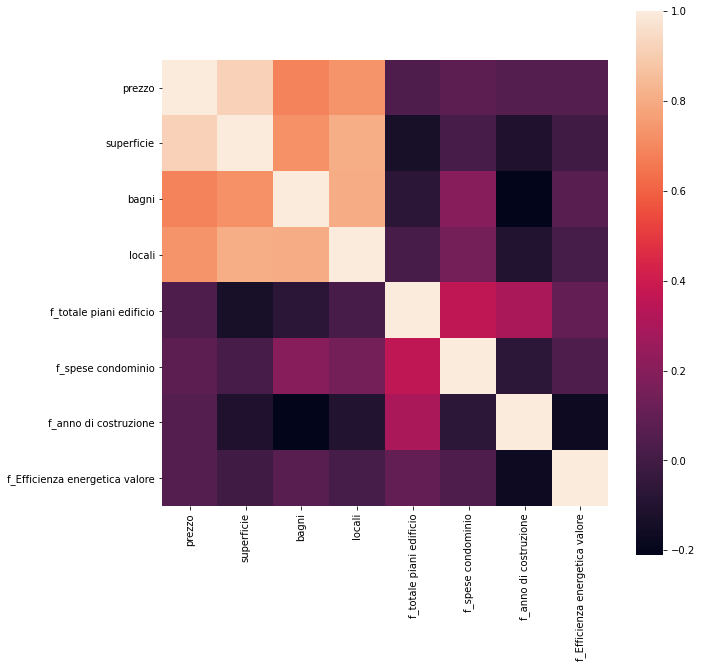

In [306]:
#df_ads_columns_2 = df_ads_columns
df_ads_columns_2 = df_ads_columns[(df_ads_columns['quartiere'] == 'Duomo')]
#display(df_ads_columns_2.head(10))
print(len(df_ads_columns_2.index))
plt.figure(figsize=(10, 10))
sb.heatmap(df_ads_columns_2.corr(), square = True)